## Self-RAG

This notebook implements Self-RAG (Self-Reflective Retrieval-Augmented Generation), which combines:
- Document relevance grading
- Hallucination detection
- Answer completeness checking
- Query rewriting for better retrieval

Flow:
1. Query -> Retrieve -> Grade documents
2. If relevant -> Generate -> Check hallucinations -> Check answer quality
3. If not relevant -> Transform query -> Retrieve again
4. If hallucinations -> Regenerate
5. If doesn't answer query -> Transform query -> Retrieve again

In [1]:
from typing_extensions import TypedDict
from typing import List
import os

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [3]:
# =============================================================================
# Pydantic Schemas for Structured Outputs
# =============================================================================

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents"""
    binary_score: str = Field(description="Documents are relevant to the query, 'yes' or 'no'")

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer"""
    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses query"""
    binary_score: str = Field(description="Answer addresses the query, 'yes' or 'no'")

class SearchQueries(BaseModel):
    """Search queries for retrieving missing information"""
    search_queries: List[str] = Field(description="1-3 search queries to retrieve missing information")

In [4]:
# =============================================================================
# State
# =============================================================================

class AgentState(TypedDict):
    query: str
    generation: str
    documents: str
    filtered_documents: str
    rewritten_queries: List[str]

In [5]:
# =============================================================================
# LangGraph Nodes
# =============================================================================

# Retrieve documents based on user query
def retrieve_node(state:AgentState):
    print("[RETRIEVE] Fetching documents")

    query = state["query"]
    rewritten_queries = state.get("rewritten_queries", [])

    # Use rewritten queries if present, otherwise use original query
    queries_to_search = rewritten_queries if rewritten_queries else [query]

    all_results = []
    for idx, search_query in enumerate(queries_to_search, 1):
        print(f"[RETRIEVE] {idx} Query: {search_query}")
        result = my_tools.retrieve_docs.invoke({'query': search_query, 'k': 3})
        all_results.append(f"## Query {idx}: {search_query}\n\n### Retrieved Documents:\n{result}")

    combined_result = "\n\n" + "\n\n".join(all_results)
    print(f"[RETRIEVE] Documents fetched for {len(queries_to_search)} queries")

    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/self_rag_retrieved_docs.md", "w", encoding="utf-8") as f:
        f.write(f"Original Query: {query}\n")
        if rewritten_queries:
            f.write(f"Rewritten Queries: {rewritten_queries}\n\n")
        f.write(combined_result)

    return {
        "documents": combined_result,
        "query": query
    }

In [6]:
# Grade document relevance and filter out irrelevant ones
def grade_documents_node(state:AgentState):
    print("[GRADE] Evaluating document relevance")

    query = state["query"]
    documents = state.get("documents", "")

    llm_structured = llm.with_structured_output(GradeDocuments)

    system_prompt = """You are a grader assessing relevance of retrieved documents to a user query.

It does not need to be a stringent test. The goal is to filter out erroneous retrievals.

If the document contains keyword(s) or semantic meaning related to the user query, grade it as relevant.

Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the query."""

    system_msg = SystemMessage(system_prompt)
    user_msg = HumanMessage(f"Retrieved documents:\n\n{documents}\n\nUser query: {query}")
    
    messages = [system_msg, user_msg]
    response = llm_structured.invoke(messages)

    print(f"[GRADE] Relevance: {response.binary_score}")

    if response.binary_score == "yes":
        return {
            "filtered_documents": documents,
            "query": query
        }
    else:
        return {
            "filtered_documents": "",
            "query": query
        }

In [7]:
# Generate answer based on retrieved documents
def generate_node(state:AgentState):
    print("[GENERATE] Creating answer")

    query = state["query"]
    documents = state.get("filtered_documents", "")

    system_prompt = """You are a financial document analyst providing detailed, accurate answers.

OUTPUT FORMAT:
Write a comprehensive answer (200-300 words) in MARKDOWN format:
- Use ## headings for sections
- Use **bold** for emphasis
- Use bullet points or numbered lists
- Include inline citations like [1], [2] where applicable

GUIDELINES:
- Base your answer ONLY on the provided documents
- Be specific with numbers, dates, and metrics
- If information is missing, acknowledge it
- Use proper financial terminology

CITATIONS:
At the end, list references in this format:
**References:**
1. Company: x, Year: y, Quarter: z, Page: n"""

    query_prompt = f"Documents:\n\n{documents}\n\nQuery: {query}"

    system_msg = SystemMessage(system_prompt)
    user_msg = HumanMessage(query_prompt)
    
    messages = [system_msg, user_msg]
    response = llm.invoke(messages)
    
    generation = response.content

    print(f"[GENERATE] Answer created ({len(generation)} chars)")

    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/self_rag_generation.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(generation)

    return {
        "generation": generation,
        "documents": documents,
        "query": query
    }

In [8]:
# Transform the query to produce better search queries
def transform_query_node(state:AgentState):
    print("[TRANSFORM] Rewriting query")

    query = state["query"]
    rewritten_queries = state.get("rewritten_queries", [])

    llm_structured = llm.with_structured_output(SearchQueries)

    system_prompt = """You are a query re-writer that decomposes complex queries into focused search queries optimized for vectorstore retrieval.

DECOMPOSITION STRATEGY:
Break down the original query into 1-3 specific, focused queries where each query targets:
- A single company (e.g., "Amazon revenue 2023" vs "Google revenue 2023")
- A specific time period (e.g., "Q1 2024" vs "Q2 2024")
- A specific metric or aspect (e.g., "revenue" vs "net income")
- A specific document section (e.g., "risk factors" vs "business overview")

GUIDELINES:
- Expand abbreviations (e.g., "rev" -> "revenue", "GOOGL" -> "Google")
- Add financial context if missing
- Make each query self-contained and specific
- Keep queries concise but clear (5-10 words each)
- Avoid repeating previously tried queries

EXAMPLES:
- "Compare Apple and Google revenue in 2024 Q1" → 
  ["Apple total revenue Q1 2024", "Google total revenue Q1 2024"]
  
- "Amazon's revenue growth from 2022 to 2024" →
  ["Amazon revenue 2022", "Amazon revenue 2023", "Amazon revenue 2024"]
  
- "What were the main risks for Microsoft in 2023?" →
  ["Microsoft risk factors 2023", "Microsoft business challenges 2023"]"""

    query_context = f"Original query: {query}"
    if rewritten_queries:
        query_context += f"\n\nPreviously tried queries:\n" + "\n".join(f"- {q}" for q in rewritten_queries)
    query_context += "\n\nGenerate 1-3 focused search queries that decompose the original query. Each query should target a specific aspect."

    system_msg = SystemMessage(system_prompt)
    user_msg = HumanMessage(query_context)
    
    messages = [system_msg, user_msg]
    response = llm_structured.invoke(messages)
    
    new_queries = response.search_queries

    print(f"[TRANSFORM] Original: {query}")
    print(f"[TRANSFORM] Decomposed Queries: {new_queries}")

    return {
        "query": query,
        "rewritten_queries": new_queries
    }

In [9]:
# =============================================================================
# Router Logic
# =============================================================================

# Decide whether to generate answer or transform query
def should_generate(state:AgentState):
    print("[ROUTER] Assess graded documents")

    filtered_documents = state.get("filtered_documents", "")

    if not filtered_documents or filtered_documents.strip() == "":
        print("[ROUTER] No relevant documents - transforming query")
        return "transform_query"
    else:
        print("[ROUTER] Have relevant documents - generating answer")
        return "generate"

In [10]:
# Check for hallucinations and whether answer addresses query
def check_answer_quality(state:AgentState):
    print("[ROUTER] Check hallucinations and answer quality")

    query = state["query"]
    documents = state.get("filtered_documents", "")
    generation = state.get("generation", "")

    # Step 1: Check hallucinations
    print("[ROUTER] Checking hallucinations")
    llm_hallucination = llm.with_structured_output(GradeHallucinations)

    hallucination_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.

Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

    system_msg = SystemMessage(hallucination_prompt)
    user_msg = HumanMessage(f"Set of facts:\n\n{documents}\n\nLLM generation: {generation}")
    
    messages = [system_msg, user_msg]
    hallucination_response = llm_hallucination.invoke(messages)
    
    hallucination_grade = hallucination_response.binary_score

    if hallucination_grade == "yes":
        print("[ROUTER] Generation is grounded in documents")

        # Step 2: Check if answer addresses query
        print("[ROUTER] Checking answer quality")
        llm_answer = llm.with_structured_output(GradeAnswer)

        answer_prompt = """You are a grader assessing whether an answer addresses / resolves a query.

Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the query."""

        system_msg = SystemMessage(answer_prompt)
        user_msg = HumanMessage(f"User query:\n\n{query}\n\nLLM generation: {generation}")
        
        messages = [system_msg, user_msg]
        answer_response = llm_answer.invoke(messages)
        
        answer_grade = answer_response.binary_score

        if answer_grade == "yes":
            print("[ROUTER] Generation addresses query - USEFUL")
            return END
        else:
            print("[ROUTER] Generation does NOT address query - NOT USEFUL")
            return "transform_query"
    else:
        print("[ROUTER] Generation NOT grounded in documents - NOT SUPPORTED")
        return "generate"

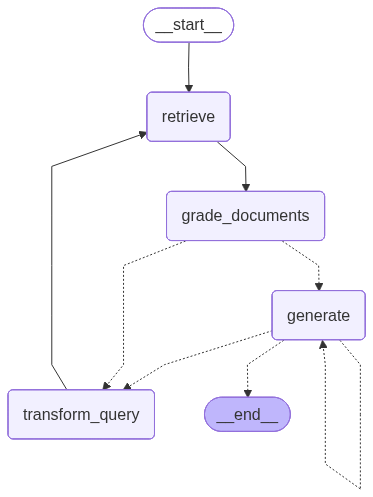

In [11]:
# =============================================================================
# Build Graph
# =============================================================================

def create_self_rag():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('retrieve', retrieve_node)
    builder.add_node('grade_documents', grade_documents_node)
    builder.add_node('generate', generate_node)
    builder.add_node('transform_query', transform_query_node)

    # define edges
    builder.add_edge(START, 'retrieve')
    builder.add_edge('retrieve', 'grade_documents')
    builder.add_edge('transform_query', 'retrieve')

    # conditional edges
    builder.add_conditional_edges('grade_documents', should_generate, ['transform_query', 'generate'])
    builder.add_conditional_edges('generate', check_answer_quality, ['generate', END, 'transform_query'])

    return builder.compile()

graph = create_self_rag()
graph

In [12]:
# =============================================================================
# Demo
# =============================================================================

result = graph.invoke({
    "query": "What was Amazon's revenue in 2023?",
    "rewritten_queries": []
})

[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: What was Amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Amazon's revenue in 2023?
   [1] Doc 19: score=21.1139
   [2] Doc 10: score=20.5240
   [3] Doc 2: score=19.3040
[RETRIEVED] 3 documents
[RETRIEVE] Documents fetched for 1 queries
[GRADE] Evaluating document relevance
[GRADE] Relevance: yes
[ROUTER] Assess graded documents
[ROUTER] Have relevant documents - generating answer
[GENERATE] Creating answer
[GENERATE] Answer created (1515 chars)
[ROUTER] Check hallucinations and answer quality
[ROUTER] Checking hallucinations
[ROUTER] Generation is grounded in documents
[ROUTER] Checking answer quality
[ROUTER] Generation addresses query - USEFUL


In [13]:
print(result['generation'])

## Amazon's Revenue in 2023

Amazon's total **revenue (net sales)** for the fiscal year ended December 31, 2023, was **$574.785 billion** [3]. This figure is derived from the consolidated segment reporting in the 10-K filing, which aggregates revenue from North America, International, and AWS segments. 

### Breakdown of Revenue by Segment
- **North America**: $352.828 billion (61% of total revenue)  
- **International**: $131.200 billion (23% of total revenue)  
- **AWS**: $90.757 billion (16% of total revenue)  

### Year-over-Year Growth
- **Overall Growth**: 12% increase compared to 2022 ($513.983 billion) [3].  
- **North America**: 12% growth [3].  
- **International**: 11% growth, partially influenced by favorable foreign exchange rates (which added $88 million to net sales) [3].  
- **AWS**: 13% growth, driven by continued demand for cloud services [3].  

### Key Drivers
Revenue growth was fueled by:  
- Increased unit sales, particularly from third-party sellers, advertising 

In [14]:
result = graph.invoke({
    "query": "Compare Apple and Amazon revenue in 2024 q1",
    "rewritten_queries": []
})

print(result['generation'])

[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: Compare Apple and Amazon revenue in 2024 q1

[TOOL] retrieve_docs called
[QUERY] Compare Apple and Amazon revenue in 2024 q1
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[RETRIEVE] Documents fetched for 1 queries
[GRADE] Evaluating document relevance
[GRADE] Relevance: no
[ROUTER] Assess graded documents
[ROUTER] No relevant documents - transforming query
[TRANSFORM] Rewriting query
[TRANSFORM] Original: Compare Apple and Amazon revenue in 2024 q1
[TRANSFORM] Decomposed Queries: ['Apple total revenue Q1 2024', 'Amazon total revenue Q1 2024']
[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: Apple total revenue Q1 2024

[TOOL] retrieve_docs called
[QUERY] Apple total revenue Q1 2024
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[RETRIEVE] 2 Query: Amazon total revenue Q1 2024

[TOOL] retrieve_docs called
[QUERY] Am

In [15]:
result = graph.invoke({
    "query": "What was Google's revenue in 2023?",
    "rewritten_queries": []
})

print(result['generation'])

[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: What was Google's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Google's revenue in 2023?
   [1] Doc 21: score=25.8314
   [2] Doc 5: score=23.4856
   [3] Doc 16: score=21.7380
[RETRIEVED] 3 documents
[RETRIEVE] Documents fetched for 1 queries
[GRADE] Evaluating document relevance
[GRADE] Relevance: no
[ROUTER] Assess graded documents
[ROUTER] No relevant documents - transforming query
[TRANSFORM] Rewriting query
[TRANSFORM] Original: What was Google's revenue in 2023?
[TRANSFORM] Decomposed Queries: ['Google total revenue 2023', 'Google revenue 2023 financial report']
[RETRIEVE] Fetching documents
[RETRIEVE] 1 Query: Google total revenue 2023

[TOOL] retrieve_docs called
[QUERY] Google total revenue 2023
   [1] Doc 23: score=25.4276
   [2] Doc 5: score=22.7817
   [3] Doc 16: score=21.3539
[RETRIEVED] 3 documents
[RETRIEVE] 2 Query: Google revenue 2023 financial report

[TOOL] retrieve_docs called
[QUERY] Google revenue 